In [466]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [467]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Clustering

In [468]:
features = pd.read_csv('item_features.csv')

In [469]:
n_pca_comp = 15
number_of_clusters = 10

In [470]:
features_ones = features.copy()
features_ones["feature_value_id"]=1
features_ones = features_ones.dropna()
features_ones = features_ones.pivot_table(values='feature_value_id', index='item_id', columns='feature_category_id', aggfunc='first')
features_ones = features_ones.replace(np.nan, 0)
features_matrix = features.pivot_table(values='feature_value_id', index='item_id', columns='feature_category_id', aggfunc='first')

In [471]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
features_scaled=ss.fit_transform(features_ones)
features_scaled= pd.DataFrame(features_scaled)

In [472]:
#running PCA with kmeans 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca_comp=PCA(n_components=n_pca_comp)
df_reduced_comp=pca_comp.fit_transform(features_scaled)

# running Kmeans for 5 clusters on 2 PC's
kmeans_pca_comp=KMeans(n_clusters=number_of_clusters)
reduced_cluster_labels_comp=kmeans_pca_comp.fit_predict(df_reduced_comp)
centers_comp=kmeans_pca_comp.cluster_centers_

#creating dataframes for cluster labels and 2 PC's
cluster_assign=pd.DataFrame(reduced_cluster_labels_comp,columns=['Cluster_pred'])

In [473]:
cluster_assign["item_id2"]=np.unique(features[['item_id']].values).tolist()
#print(np.unique(features[['item_id']].values).tolist())
cluster_assign.head()

,Cluster_pred,item_id2
0,3,2
1,0,3
2,0,4
3,2,7
4,0,8


# Dataset train_sessions

- Primer producto visto
- Fecha de visualización del primer producto
- Último producto visto
- Fecha de visualización del último producto
- Tiempo total de sesión (s)
- Promedio de tiempo en artículos
- Momento del día de inicio de sesión
- Una cadena de productos vistos en orden

In [474]:
df_sessions = pd.read_csv('train_sessions.csv')

In [475]:
df_sessions.head()

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211


In [476]:
session_sorted = df_sessions.sort_values(by=['date'])

# First date of session
begin_df = session_sorted.groupby('session_id')['date'].first().rename('start_date')

# First product of session
first_prod=session_sorted.groupby('session_id')['item_id'].first().rename('first_prod')

# Number of products seen in the session
prod_count=session_sorted.groupby('session_id')['item_id'].count().rename('prod_count')

# Last date of the session
end_df = session_sorted.groupby('session_id')['date'].last().rename('end_date')

# Last product of the session
last_prod=session_sorted.groupby('session_id')['item_id'].first().rename('last_prod')

# Concat the datasets
times_df=pd.concat([begin_df,end_df,first_prod,last_prod,prod_count],axis=1)

# Proper time format
times_df['start_date']=pd.to_datetime(times_df['start_date'])
times_df['end_date']=pd.to_datetime(times_df['end_date'])

# Calculatind the date difference
times_df['time_diff']=(times_df.end_date-times_df.start_date).astype('timedelta64[s]')

# Calculating the time per product
times_df['time_per_prod']=times_df['time_diff']/times_df['prod_count']

# Adding the time of the day
mask=(times_df.start_date.dt.hour>=0) & (times_df.start_date.dt.hour<7)
times_df.loc[mask,'time_first_prod']='madrugada'
mask=(times_df.start_date.dt.hour>=7) & (times_df.start_date.dt.hour<12)
times_df.loc[mask,'time_first_prod']='día'
mask=(times_df.start_date.dt.hour>=12) & (times_df.start_date.dt.hour<18)
times_df.loc[mask,'time_first_prod']='tarde'
mask=(times_df.start_date.dt.hour>=18) & (times_df.start_date.dt.hour<24)
times_df.loc[mask,'time_first_prod']='noche'


In [477]:
# Get the product chain
df_sessions['idx'] = df_sessions.groupby('session_id').cumcount()
df_sessions['item_idx'] = 'product_' + df_sessions.idx.astype(str)

item = df_sessions.pivot(index='session_id',columns='item_idx',values='item_id')

item['item_serie']=item.astype(str).agg('-'.join,axis=1)

item['item_serie'].replace(r'.0','', regex=True, inplace=True)
item['item_serie'].replace(r'-nan','', regex=True, inplace=True)

item.head()

item_idx,product_0,product_1,product_10,product_11,product_12,product_13,product_14,product_15,product_16,product_17,...,product_91,product_92,product_93,product_94,product_95,product_96,product_97,product_98,product_99,item_serie
session_id,,,,,,,,,,,,,,,,,,,,,
3,9655.0,9655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9655-9655
13,15654.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15654
18,18316.0,2507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18316-27-26
19,25772.0,6341.0,8813.0,19896.0,27937.0,23687.0,12804.0,1755.0,18936.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25772-6341-8813-19896-27937-23687-124-1755-189...
24,2927.0,11662.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2927-11662-2927-275-434-164-414-18539-18476


In [478]:
sessions=pd.concat([times_df,item['item_serie']], axis=1)
sessions

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,item_serie
session_id,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,312.0,156.000000,noche,9655-9655
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,0.0,0.000000,noche,15654
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,163.0,54.333333,noche,18316-27-26
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,1082.0,63.647059,tarde,25772-6341-8813-19896-27937-23687-124-1755-189...
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,3703.0,411.444444,tarde,2927-11662-2927-275-434-164-414-18539-18476
...,...,...,...,...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:55:50.151,23502,23502,6,533.0,88.833333,día,13914-193-133-232-27733-12373
4439990,2020-08-22 11:38:48.785,2020-08-22 12:36:27.326,22093,22093,11,3458.0,314.363636,día,1389-293-293-7833-189-1131-28-17429-62-22551-211
4439994,2020-11-27 20:08:37.262,2020-11-27 20:08:37.262,25357,25357,1,0.0,0.000000,noche,25357


# Purchases

In [479]:
purchases = pd.read_csv('train_purchases.csv').set_index('session_id')
purchases['date']=pd.to_datetime(purchases['date'])
purchases.rename(columns={'item_id':'item_purch','date':'purch_date'}, inplace=True)
purchases.head()

,item_purch,purch_date
session_id,,
3,15085,2020-12-18 21:26:47.986
13,18626,2020-03-13 19:36:15.507
18,24911,2020-08-26 19:20:32.049
19,12534,2020-11-02 17:16:45.920
24,13226,2020-02-26 18:27:44.114


In [480]:
purchases.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 3 to 4440001
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   item_purch  1000000 non-null  int64         
 1   purch_date  1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.9 MB


# Features
- Tabla con sesiones y veces que se ha visto cada clúster

In [481]:
item_clust=cluster_assign[['item_id2', 'Cluster_pred']].set_index('item_id2')
item_clust

,Cluster_pred
item_id2,
2,3
3,0
4,0
7,2
8,0
...,...
28139,0
28140,4
28141,0


In [482]:
df_sess_clust=df_sessions.merge(item_clust, left_on='item_id', right_index=True)
df_sess_clust

,session_id,item_id,date,idx,item_idx,Cluster_pred
0,3,9655,2020-12-18 21:25:00.373,0,product_0,4
1,3,9655,2020-12-18 21:19:48.093,1,product_1,4
103605,97085,9655,2020-12-27 20:22:13.011,3,product_3,4
162423,152155,9655,2020-11-19 16:26:18.468,1,product_1,4
225780,210806,9655,2021-01-02 05:37:37.183,8,product_8,4
...,...,...,...,...,...,...
4737630,4434058,3416,2020-11-14 23:33:46.655,2,product_2,0
4737631,4434058,15964,2020-11-14 23:33:58.652,3,product_3,0
4739963,4436170,27863,2020-07-20 06:36:30.611,0,product_0,2
4741053,4437232,7735,2020-01-02 20:07:06.367,7,product_7,0


In [483]:
df_clust_count = df_sess_clust.groupby(['session_id', 'Cluster_pred'])['session_id'].aggregate('count').unstack().fillna(0)


In [484]:
df_clust_count

Cluster_pred,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,3.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4439986,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
4439990,8.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4439994,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Combinar los datasets

In [485]:
df=pd.concat([sessions, purchases, df_clust_count], axis=1)
df

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,item_serie,item_purch,...,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,,,,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,312.0,156.000000,noche,9655-9655,15085,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,0.0,0.000000,noche,15654,18626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,163.0,54.333333,noche,18316-27-26,24911,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,1082.0,63.647059,tarde,25772-6341-8813-19896-27937-23687-124-1755-189...,12534,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,3703.0,411.444444,tarde,2927-11662-2927-275-434-164-414-18539-18476,13226,...,0.0,0.0,3.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:55:50.151,23502,23502,6,533.0,88.833333,día,13914-193-133-232-27733-12373,2915,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
4439990,2020-08-22 11:38:48.785,2020-08-22 12:36:27.326,22093,22093,11,3458.0,314.363636,día,1389-293-293-7833-189-1131-28-17429-62-22551-211,8786,...,8.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4439994,2020-11-27 20:08:37.262,2020-11-27 20:08:37.262,25357,25357,1,0.0,0.000000,noche,25357,21630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [486]:
df['item_purch'].nunique()

18907

In [487]:
df = df[df.index<100000]

df

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,item_serie,item_purch,...,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,,,,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,312.0,156.000000,noche,9655-9655,15085,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,0.0,0.000000,noche,15654,18626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,163.0,54.333333,noche,18316-27-26,24911,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,1082.0,63.647059,tarde,25772-6341-8813-19896-27937-23687-124-1755-189...,12534,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,3703.0,411.444444,tarde,2927-11662-2927-275-434-164-414-18539-18476,13226,...,0.0,0.0,3.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987,2021-03-26 21:32:41.830,2021-03-26 21:32:41.830,7733,7733,1,0.0,0.000000,noche,7733,17761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99989,2021-02-14 20:01:45.709,2021-02-14 20:01:45.709,10474,10474,1,0.0,0.000000,noche,474,8844,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
99990,2020-05-19 02:19:51.688,2020-05-19 02:19:51.688,11117,11117,1,0.0,0.000000,madrugada,11117,7663,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [488]:
df.to_csv('dataset_merge.csv')

<AxesSubplot:>

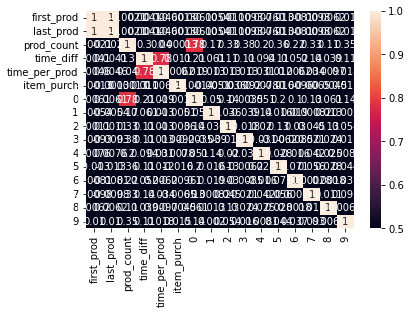

In [489]:
sns.heatmap(df.corr(), annot=True, vmin=0.5) # new 

In [490]:
print(number_of_clusters)

10


### How many type of items are seen in each session?

In [491]:
df_clusts = df[range(number_of_clusters)]
df_clusts = df_clusts.replace(0, np.nan)
df_clusts["distinct"] = df_clusts.count(1)
#df_clusts.head()
item_counts = df_clusts["distinct"].value_counts()
print(item_counts)

1    14230
2     4883
3     2039
4      844
5      318
6      117
7       42
8       12
9        2
Name: distinct, dtype: int64


## Divide into train - validation

There are several ways to divide your training data. Sometimes it is important to create a stratified sampling.

In [492]:
df_clusts = df[range(number_of_clusters)]
df_clusts = df_clusts.replace(0, np.nan)
df_clusts["sum"] = df_clusts.sum(axis=1)
df_clusts = df_clusts[df_clusts["sum"] > 4.0]
df_clusts["distinct"] = df_clusts[range(number_of_clusters)].count(1)
df_clusts.head()
item_counts = df_clusts["distinct"].value_counts()
print(item_counts)

2    2372
1    2005
3    1636
4     815
5     318
6     117
7      42
8      12
9       2
Name: distinct, dtype: int64


In [493]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
len(train_set),len(test_set)

(17989, 4498)

## Prepare the data for Machine Learning algorithms

In [494]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown='ignore')
train_set_1hot = cat_encoder.fit_transform(train_set.fillna('Unknown'))

In [495]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [496]:
train_set_num = train_set[["prod_count", "time_diff", "time_per_prod"] + list(range(number_of_clusters))]

In [497]:
imputer.fit(train_set_num)
imputer.statistics_

array([  3.        , 107.        ,  30.33333333,   1.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

In [498]:
train_set_num.median().values

array([  3.        , 107.        ,  30.33333333,   1.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

In [499]:
X = imputer.transform(train_set_num)

In [500]:
train_set_tr = pd.DataFrame(X, columns=train_set_num.columns,
                          index=train_set.index)

In [501]:
imputer.strategy

'median'

In [502]:
train_set_tr.head()

,prod_count,time_diff,time_per_prod,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,,,,
61129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
46627,3.0,72.0,24.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
92279,2.0,33.0,16.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58133,4.0,94.0,23.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57270,2.0,31.0,15.5,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


### Categorical data

Now let's preprocess the categorical input time_first_prod:

In [503]:
train_set_cat = train_set[["first_prod", "last_prod", "time_first_prod"]]
# There is missing values in this category, we will create a new cateogry for those.
train_set_cat.fillna('Unknown').head(10)

,first_prod,last_prod,time_first_prod
session_id,,,
61129,10165,10165,día
46627,13709,13709,tarde
92279,6035,6035,día
58133,19772,19772,noche
57270,15742,15742,día
24908,20205,20205,tarde
37860,12631,12631,día
83819,17428,17428,día
41415,17484,17484,madrugada


In [504]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
train_set_cat_encoded = ordinal_encoder.fit_transform(train_set_cat.fillna('Unknown'))
train_set_cat_encoded[:10]

array([[2.854e+03, 2.854e+03, 0.000e+00],
       [3.841e+03, 3.841e+03, 3.000e+00],
       [1.673e+03, 1.673e+03, 0.000e+00],
       [5.521e+03, 5.521e+03, 2.000e+00],
       [4.409e+03, 4.409e+03, 0.000e+00],
       [5.651e+03, 5.651e+03, 3.000e+00],
       [3.533e+03, 3.533e+03, 0.000e+00],
       [4.870e+03, 4.870e+03, 0.000e+00],
       [4.883e+03, 4.883e+03, 1.000e+00],
       [1.562e+03, 1.562e+03, 0.000e+00]])

In [505]:
ordinal_encoder.categories_

[array([   13,    20,    26, ..., 28135, 28137, 28140]),
 array([   13,    20,    26, ..., 28135, 28137, 28140]),
 array(['día', 'madrugada', 'noche', 'tarde'], dtype=object)]

In [506]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown='ignore')
train_set_cat_1hot = cat_encoder.fit_transform(train_set_cat.fillna('Unknown'))
train_set_cat_1hot

<17989x15710 sparse matrix of type '<class 'numpy.float64'>'
	with 53967 stored elements in Compressed Sparse Row format>

In [507]:
train_set_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [508]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

train_set_num_tr = num_pipeline.fit_transform(train_set_num)

In [509]:
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

In [510]:
from sklearn.compose import ColumnTransformer

num_attribs1 = train_set_num.select_dtypes(include="object").columns
cat_attribs = train_set_cat.select_dtypes(include="object").columns


full_pipeline = ColumnTransformer([
        ("num1", num_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
    ])

train_set_prepared = full_pipeline.fit_transform(train_set)

train_set_prepared

<17989x4 sparse matrix of type '<class 'numpy.float64'>'
	with 17989 stored elements in Compressed Sparse Row format>

## Select and train a model

### Linear Regression

In [511]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_set_prepared, train_set[["item_purch"]])

LinearRegression()

In [512]:
from sklearn.metrics import mean_squared_error

train_set_predictions = lin_reg.predict(train_set_prepared)
lin_mse = mean_squared_error(train_set[["item_purch"]], train_set_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

8208.165072846828

RandomForestRegressor

In [513]:
## Let's try another model: Random Forest
from sklearn.ensemble import RandomForestClassifier

forest_class = RandomForestClassifier(n_estimators=20, random_state=42)
forest_class.fit(train_set_prepared, train_set[["item_purch"]].to_numpy().ravel())

RandomForestClassifier(n_estimators=20, random_state=42)

In [514]:
train_set_predictions = forest_class.predict(train_set_prepared)
forest_mse = mean_squared_error(train_set[["item_purch"]].to_numpy().ravel(), train_set_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse
forest_class.score(train_set_prepared, train_set[["item_purch"]].to_numpy().ravel())
#forest_reg.predict()

0.007337817555172606

In [515]:
test_set_num = test_set[["prod_count", "time_diff", "time_per_prod"] + list(range(number_of_clusters))]
test_set_cat = test_set[["first_prod", "last_prod", "time_first_prod"]]

num_attribs2 = test_set_num.select_dtypes(include="object").columns
cat_attribs2 = test_set_cat.select_dtypes(include="object").columns


full_pipeline = ColumnTransformer([
        ("num1", num_pipeline, num_attribs2),
        ("cat", cat_pipeline, cat_attribs2),
    ])

test_set_prepared = full_pipeline.fit_transform(test_set)

forest_class.score(test_set_prepared, test_set[["item_purch"]].to_numpy().ravel())

predictions = forest_class.predict_proba(test_set_prepared)

In [516]:
len(forest_class.classes_)

7777

In [517]:
forest_class.classes_

array([   18,    26,    28, ..., 28137, 28139, 28140])

In [518]:
session_list = []
for i in test_set["item_purch"].to_numpy():
    listofzeros = [0] * len(forest_class.classes_)
    if i in forest_class.classes_.tolist():
        idx = forest_class.classes_.tolist().index(i)
        listofzeros[idx] = 1
    session_list.append(listofzeros)

In [519]:
from sklearn.metrics import label_ranking_average_precision_score

lrap = label_ranking_average_precision_score(session_list, predictions)

In [520]:
print(lrap)

0.24064412331451165


In [521]:
f = open('test_set_session.csv', 'w')
f.write('session_id,item_id,rank' + '\n')
for i in range(len(predictions)):
    dicc={}
    for j in range(len(forest_class.classes_)):
        dicc[forest_class.classes_[j]] = predictions[i][j]
    dicc1 = {k: v for k, v in sorted(dicc.items(), key=lambda item: item[1], reverse=True)}
    for a in range(1,101):
        l = list(dicc1.items())[:101]
        f.write(str(test_set.index[i]) + ',' + str(l[a][0]) + ',' + str(a) + '\n')

predictions_proba = pd.read_csv('test_set_session.csv')

In [522]:
print(predictions.shape)

(4498, 7777)


## Generate TEST Submission

In [523]:
df_leader = pd.read_csv('test_leaderboard_sessions.csv')

In [524]:
leader_session_sorted = df_leader.sort_values(by=['date'])

# First date of session
leader_begin_df = leader_session_sorted.groupby('session_id')['date'].first().rename('start_date')

# First product of session
leader_first_prod=leader_session_sorted.groupby('session_id')['item_id'].first().rename('first_prod')

# Number of products seen in the session
leader_prod_count=leader_session_sorted.groupby('session_id')['item_id'].count().rename('prod_count')

# Last date of the session
leader_end_df = leader_session_sorted.groupby('session_id')['date'].last().rename('end_date')

# Last product of the session
leader_last_prod=leader_session_sorted.groupby('session_id')['item_id'].first().rename('last_prod')

# Concat the datasets
leader_times_df=pd.concat([leader_begin_df,leader_end_df,leader_first_prod,leader_last_prod,leader_prod_count],axis=1)

# Proper time format
leader_times_df['start_date']=pd.to_datetime(leader_times_df['start_date'])
leader_times_df['end_date']=pd.to_datetime(leader_times_df['end_date'])

# Calculatind the date difference
leader_times_df['time_diff']=(leader_times_df.end_date-leader_times_df.start_date).astype('timedelta64[s]')

# Calculating the time per product
leader_times_df['time_per_prod']=leader_times_df['time_diff']/leader_times_df['prod_count']

# Adding the time of the day
mask=(leader_times_df.start_date.dt.hour>=0) & (leader_times_df.start_date.dt.hour<7)
leader_times_df.loc[mask,'time_first_prod']='madrugada'
mask=(leader_times_df.start_date.dt.hour>=7) & (leader_times_df.start_date.dt.hour<12)
leader_times_df.loc[mask,'time_first_prod']='día'
mask=(leader_times_df.start_date.dt.hour>=12) & (leader_times_df.start_date.dt.hour<18)
leader_times_df.loc[mask,'time_first_prod']='tarde'
mask=(leader_times_df.start_date.dt.hour>=18) & (leader_times_df.start_date.dt.hour<24)
leader_times_df.loc[mask,'time_first_prod']='noche'

In [525]:
leader_times_df

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod
session_id,,,,,,,,
26,2021-06-16 09:53:54.158,2021-06-16 09:53:54.158,19185,19185,1,0.0,0.000000,día
200,2021-06-25 12:23:40.811,2021-06-25 12:24:50.692,17089,17089,4,69.0,17.250000,tarde
205,2021-06-11 00:28:07.058,2021-06-11 00:28:07.058,8194,8194,1,0.0,0.000000,madrugada
495,2021-06-14 22:13:06.741,2021-06-14 22:13:06.741,6853,6853,1,0.0,0.000000,noche
521,2021-06-19 13:50:03.090,2021-06-19 13:50:03.090,26471,26471,1,0.0,0.000000,tarde
...,...,...,...,...,...,...,...,...
4439446,2021-06-11 17:16:12.243,2021-06-11 17:17:11.565,20770,20770,3,59.0,19.666667,tarde
4439458,2021-06-09 04:52:02.785,2021-06-09 04:54:45.378,11715,11715,2,162.0,81.000000,madrugada
4439550,2021-06-02 17:42:40.481,2021-06-02 17:42:40.481,19086,19086,1,0.0,0.000000,tarde


In [526]:
df_sess_clust_leader=df_leader.merge(item_clust, left_on='item_id', right_index=True)
df_sess_clust_leader

,session_id,item_id,date,Cluster_pred
0,26,19185,2021-06-16 09:53:54.158,0
13240,239993,19185,2021-06-21 11:22:20.096,0
34682,661695,19185,2021-06-27 09:31:21.179,0
36264,699226,19185,2021-06-07 09:58:16.167,0
42810,830528,19185,2021-06-14 15:26:44.282,0
...,...,...,...,...
226231,4382253,7523,2021-06-18 14:05:33.111,9
227011,4397116,6327,2021-06-23 21:59:23.999,5
227515,4408745,10278,2021-06-06 11:23:56.511,4
228684,4428903,27394,2021-06-16 17:03:01.114,0


In [527]:
df_sess_clust

,session_id,item_id,date,idx,item_idx,Cluster_pred
0,3,9655,2020-12-18 21:25:00.373,0,product_0,4
1,3,9655,2020-12-18 21:19:48.093,1,product_1,4
103605,97085,9655,2020-12-27 20:22:13.011,3,product_3,4
162423,152155,9655,2020-11-19 16:26:18.468,1,product_1,4
225780,210806,9655,2021-01-02 05:37:37.183,8,product_8,4
...,...,...,...,...,...,...
4737630,4434058,3416,2020-11-14 23:33:46.655,2,product_2,0
4737631,4434058,15964,2020-11-14 23:33:58.652,3,product_3,0
4739963,4436170,27863,2020-07-20 06:36:30.611,0,product_0,2
4741053,4437232,7735,2020-01-02 20:07:06.367,7,product_7,0


In [528]:
df_clust_count_leader = df_sess_clust_leader.groupby(['session_id', 'Cluster_pred'])['session_id'].aggregate('count').unstack().fillna(0)

In [529]:
df_leader=pd.concat([leader_times_df, df_clust_count_leader], axis=1)

In [530]:
df_leader

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,,,,,,,,,
26,2021-06-16 09:53:54.158,2021-06-16 09:53:54.158,19185,19185,1,0.0,0.000000,día,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200,2021-06-25 12:23:40.811,2021-06-25 12:24:50.692,17089,17089,4,69.0,17.250000,tarde,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
205,2021-06-11 00:28:07.058,2021-06-11 00:28:07.058,8194,8194,1,0.0,0.000000,madrugada,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
495,2021-06-14 22:13:06.741,2021-06-14 22:13:06.741,6853,6853,1,0.0,0.000000,noche,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
521,2021-06-19 13:50:03.090,2021-06-19 13:50:03.090,26471,26471,1,0.0,0.000000,tarde,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439446,2021-06-11 17:16:12.243,2021-06-11 17:17:11.565,20770,20770,3,59.0,19.666667,tarde,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4439458,2021-06-09 04:52:02.785,2021-06-09 04:54:45.378,11715,11715,2,162.0,81.000000,madrugada,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4439550,2021-06-02 17:42:40.481,2021-06-02 17:42:40.481,19086,19086,1,0.0,0.000000,tarde,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [531]:
leader_set_num = df_leader[["prod_count", "time_diff", "time_per_prod", 0, 1, 3, 4, 5, 6, 7, 8, 9]]
leader_set_cat = df_leader[["first_prod", "last_prod", "time_first_prod"]]

num_attribs_leader = leader_set_num.select_dtypes(include="object").columns
cat_attribs_leader = leader_set_cat.select_dtypes(include="object").columns


full_pipeline = ColumnTransformer([
        ("num1", num_pipeline, num_attribs_leader),
        ("cat", cat_pipeline, cat_attribs_leader),
    ])

leader_set_prepared = full_pipeline.fit_transform(df_leader)

leader_set_prepared

<50000x4 sparse matrix of type '<class 'numpy.float64'>'
	with 50000 stored elements in Compressed Sparse Row format>

In [532]:
predictions = forest_class.predict_proba(leader_set_prepared)
print(predictions)

[[0.         0.         0.         ... 0.00027589 0.00016739 0.        ]
 [0.00036429 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00079784 0.         ... 0.00061275 0.         0.00067394]
 ...
 [0.00036429 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00027589 0.00016739 0.        ]
 [0.         0.         0.         ... 0.00027589 0.00016739 0.        ]]


In [533]:
forest_class.classes_

array([   18,    26,    28, ..., 28137, 28139, 28140])

In [534]:
""""
f = open('final_submission.csv', 'w')
f.write('session_id,item_id,rank' + '\n')
for i in range(len(predictions)):
    dicc={}
    for j in range(len(forest_class.classes_)):
        dicc[forest_class.classes_[j]] = predictions[i][j]
    dicc1 = {k: v for k, v in sorted(dicc.items(), key=lambda item: item[1], reverse=True)}
    for a in range(1,101):
        l = list(dicc1.items())[:101]
        f.write(str(df_leader.index[i]) + ',' + str(l[a][0]) + ',' + str(a) + '\n')
"""

'"\nf = open(\'final_submission.csv\', \'w\')\nf.write(\'session_id,item_id,rank\' + \'\n\')\nfor i in range(len(predictions)):\n    dicc={}\n    for j in range(len(forest_class.classes_)):\n        dicc[forest_class.classes_[j]] = predictions[i][j]\n    dicc1 = {k: v for k, v in sorted(dicc.items(), key=lambda item: item[1], reverse=True)}\n    for a in range(1,101):\n        l = list(dicc1.items())[:101]\n        f.write(str(df_leader.index[i]) + \',\' + str(l[a][0]) + \',\' + str(a) + \'\n\')\n'